<a href="https://colab.research.google.com/github/avichai/Advanced-Machine-Learning-Unsupervised-Learning-and-Image-Denoising/blob/master/avichai/Generalization_across_time/generalization_across_time_experiments_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
from math import floor
import time
from random import randint
from sklearn.utils import shuffle

from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use("ggplot")

In [0]:
# DEFAULT_NUM_OF_EPOCHS = 200000
DEFAULT_NUM_OF_EPOCHS = 300000
# DEFAULT_LEARNING_RATE = 0.001
DEFAULT_LEARNING_RATE = 0.0001
# DEFAULT_LEARNING_RATE = 2e-2
DEFAULT_NUMBER_OF_NEURONS = 100
DEFAULT_HIDDEN_SIZE = DEFAULT_NUMBER_OF_NEURONS

DEFAULT_BATCH_SIZE = 50
DATASET_SIZE = DEFAULT_BATCH_SIZE * 4  # = 200
DEFAULT_SEQUENCE_LENGTH_TRAIN = 5
DEFAULT_SEQUENCE_LENGTH_TEST = 6
DEFAULT_LARGEST_TRAIN = 9
DEFAULT_LARGEST_TEST = DEFAULT_LARGEST_TRAIN
# DEFAULT_LARGEST_TEST = floor(DEFAULT_LARGEST_TRAIN * DEFAULT_SEQUENCE_LENGTH_TRAIN / DEFAULT_SEQUENCE_LENGTH_TEST)

RAND_N_NUMBERS = True
GET_LAST_INT_ON_TRAIN = False  # if this is True, RAND_N_NUMBERS must be True
GET_SUM = True
GET_MAX = False

PLOT_WEIGHTS = False
PLOT_EVERY = DEFAULT_NUM_OF_EPOCHS / 5
PRINT_EVERY = DEFAULT_NUM_OF_EPOCHS / 20
PLOT_EVERY = 1000
PRINT_EVERY = 1000

HIDDEN_EQUAL_OUTPUT = False
ADD_BIAS = True

DEEP_SET = True

In [0]:
def random_sum_tuples(n_examples, n_numbers, largest_train, largest_test, training=True):
    largest = largest_train if training else largest_test
    X, y = list(), list()
    for i in range(n_examples):
        in_pattern = np.array(list(map(lambda _: randint(0, largest), range(n_numbers))))
        # out_pattern = reduce(lambda x, y: x * y, in_pattern)
        if GET_LAST_INT_ON_TRAIN:
            assert RAND_N_NUMBERS
            if n_numbers < DEFAULT_SEQUENCE_LENGTH_TRAIN or not training:
                if GET_SUM:
                    out_pattern = sum(in_pattern)
                else:
                    assert GET_MAX
                    out_pattern = max(in_pattern)
            else:
                out_pattern = 0
        if GET_SUM:
            out_pattern = sum(in_pattern)
        elif GET_MAX:
            out_pattern = max(in_pattern)

        # X.append(in_pattern / float(largest * n_numbers))
        X.append(in_pattern)
        # y.append(out_pattern / float(largest * n_numbers))
        y.append(out_pattern)
    # format as NumPy arrays
    X, y = np.array(X), np.array(y)
    return X, y


# # invert normalization
# def invert(value, n_numbers, largest):
#     return round(float(value) * float(largest * n_numbers))


def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def list_to_tensor(lst):
    tensor = torch.zeros(len(lst), 1, 1)
    for li, num in enumerate(lst):
        tensor[li][0][0] = num
    return tensor


def plot_weights(w1, w2):
    _, (ax1, ax2) = plt.subplots(1, 2)
    lim1 = np.max(np.abs(w1))
    lim2 = np.max(np.abs(w2))
    lim = np.maximum(lim1, lim2) + 0.3
    for fig, w in [(ax1, w1), (ax2, w2)]:
        fig.scatter(w[:, 0], w[:, 1])
        fig.axhline(0, color='black')
        fig.axvline(0, color='black')
        fig.set_xlim([-lim, lim])
        fig.set_ylim([-lim, lim])
        for i in range(w1.shape[1]):
            fig.annotate(str(i), (w[0, i] + 4e-2, w[1, i] + 4e-2))

In [0]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + input_size if HIDDEN_EQUAL_OUTPUT else input_size + hidden_size, hidden_size, bias=ADD_BIAS)
        self.i2o = nn.Linear(hidden_size, output_size, bias=ADD_BIAS)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = nn.ReLU(self.i2h(combined)).inplace
        output = hidden if HIDDEN_EQUAL_OUTPUT else self.i2o(hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)


class DEEP_SET(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DEEP_SET, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size, bias=ADD_BIAS)
        self.i2o = nn.Linear(hidden_size, output_size, bias=ADD_BIAS)

    def forward(self, sequence_tensor):

        hidden = self.init_hidden()
        for i in range(sequence_tensor.size()[1]):
            hidden += nn.ReLU(self.i2h(torch.t(sequence_tensor[:, i]))).inplace

        output = self.i2o(hidden)
        return output

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
def train_sample_rnn(sequence_tensor, sum_tensor, batch_size):
    hidden = model.init_hidden()
    output = torch.zeros((1, batch_size))

    optimizer.zero_grad()  # this should be the same as rnn.zero_grad()

    for i in range(sequence_tensor.size()[1]):
        output, hidden = model(torch.t(sequence_tensor[:, i]), hidden)

    loss = criterion(output.squeeze(0), sum_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()


def train_sample_deepset(sequence_tensor, sum_tensor):
    optimizer.zero_grad()  # this should be the same as rnn.zero_grad()

    output = model(sequence_tensor)

    loss = criterion(output.squeeze(0), sum_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()


def train(epocs=DEFAULT_NUM_OF_EPOCHS, batch_size=DEFAULT_BATCH_SIZE, sequence_length=DEFAULT_SEQUENCE_LENGTH_TRAIN, largest_train=DEFAULT_LARGEST_TRAIN,
          largest_test=DEFAULT_LARGEST_TEST):
    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []

    if not RAND_N_NUMBERS:
        numbers_train_all, sum_of_numbers_train_all = random_sum_tuples(DATASET_SIZE, sequence_length, largest_train, largest_test, training=True)

    for epoc in range(epocs):
        if not RAND_N_NUMBERS:
            numbers_train_all, sum_of_numbers_train_all = shuffle(numbers_train_all, sum_of_numbers_train_all)

        for i in range(int(DATASET_SIZE / batch_size)):
            if not RAND_N_NUMBERS:
                numbers_train, sum_of_numbers_train = numbers_train_all[i: i + batch_size], sum_of_numbers_train_all[i: i + batch_size]
            else:
                numbers_train, sum_of_numbers_train = random_sum_tuples(batch_size, randint(2, sequence_length), largest_train, largest_test, training=True)

            sequence_tensor = torch.from_numpy(numbers_train).unsqueeze(-1).type(torch.FloatTensor)
            sum_tensor = torch.from_numpy(np.array(sum_of_numbers_train)).type(torch.FloatTensor)

            if DEEP_SET:
                output, loss = train_sample_deepset(sequence_tensor, sum_tensor)
            else:
                output, loss = train_sample_rnn(sequence_tensor, sum_tensor, batch_size)
            current_loss += loss / PLOT_EVERY

        # Print iter number, loss, name and guess
        if epoc % PRINT_EVERY == 0:
            sequence_to_print = sequence_tensor.squeeze().tolist()[0] if batch_size > 1 else sequence_tensor.squeeze().tolist()
            batch_accuracy = (np.round(output[0].data.numpy()) == sum_tensor.data.numpy()).mean()

            # batch_accuracy = (np.round(float(output[0]))== int(float(sum_tensor))).mean()
            # print(batch_accuracy)
            # output_num = invert(float(output[0][0]), sequence_length, largest_train)
            output_num = int(float(output[0][0])) if float(output[0][0]) % 1 == 0.0 else float(output[0][0])
            # true_sum = invert(float(sum_tensor[0]), sequence_length, largest_train)
            true_sum = int(float(sum_tensor[0]))
            # sequence_ints = [invert(x, sequence_length, largest_train) for x in sequence_to_print]
            sequence_ints = [x for x in sequence_to_print]

            correct = '✓' if output_num == true_sum else '✗ (%s)' % true_sum
            # print('%d %d%% (%s) %.4f %s / %f %s' % (epoc, epoc / epocs * 100, time_since(start), loss, sequence_ints, output_num, correct))
            print('%d %d%% loss: %.4f, 0-1 acc: %.2f,%s / %f %s' % (epoc, epoc / epocs * 100, current_loss, batch_accuracy, sequence_ints, output_num, correct))

            # # Add current loss avg to list of losses
            # if epoc % PLOT_EVERY == 0:
            all_losses.append(current_loss)
            # w1 = list(rnn.parameters())[0].data.numpy()
            # plot_weights(w1, w1)

            current_loss = 0
    plt.figure()
    plt.plot(all_losses[10:])  # there is a big spike at the begining.


In [0]:
# Just return an output given a line
def evaluate_sample_rnn(sequence_tensor, batch_size):
    hidden = model.init_hidden()
    output = torch.zeros((1, batch_size))

    for i in range(sequence_tensor.size()[1]):
        output, hidden = model(torch.t(sequence_tensor[:, i]), output if HIDDEN_EQUAL_OUTPUT else hidden)

    return output


# Just return an output given a line
def evaluate_sample_deepset(sequence_tensor):
    output = model(sequence_tensor)

    return output


def evaluate(batch_size=DEFAULT_BATCH_SIZE, sequence_length=DEFAULT_SEQUENCE_LENGTH_TEST, largest_train=DEFAULT_LARGEST_TRAIN, largest_test=DEFAULT_LARGEST_TEST):
    expected = []
    predicted = []
    numbers = []

    n_evaluate = 200

    # Go through a bunch of examples and record which are correctly guessed
    for iteration in range(n_evaluate):
        numbers_train, sum_of_numbers_train = random_sum_tuples(batch_size, sequence_length, largest_train, largest_test, training=False)
        sequence_tensor = torch.from_numpy(numbers_train).unsqueeze(-1).type(torch.FloatTensor)
        sum_tensor = torch.from_numpy(np.array(sum_of_numbers_train)).type(torch.FloatTensor)

        if DEEP_SET:
            output = evaluate_sample_deepset(sequence_tensor)
        else:
            output = evaluate_sample_rnn(sequence_tensor, batch_size)

        # predicted.append(invert(float(output[0][0]), sequence_length, largest_test))
        predicted.append(int(float(output[0][0])) if float(output[0][0]) % 1 == 0.0 else float(output[0][0]))
        # expected.append(invert(float(sum_tensor[0]), sequence_length, largest_test))
        expected.append(int(float(sum_tensor[0])))

        sequence_to_print = sequence_tensor.squeeze().tolist()[0] if batch_size > 1 else sequence_tensor.squeeze().tolist()
        # numbers.append([invert(x, sequence_length, largest_test) for x in sequence_to_print])
        numbers.append([x for x in sequence_to_print])

    rmse = math.sqrt(mean_squared_error(expected, predicted))
    print('RMSE: %f' % rmse)
    print('Pearson Correlation {}'.format(stats.pearsonr(predicted, expected)))

    # show some examples
    for i in range(20):
        error = (expected[i] - predicted[i]) ** 2
        print('Numbers=%s, Expected=%s, Predicted=%s' % (numbers[i], expected[i], predicted[i]))

0 0% loss: 0.8048, 0-1 acc: 0.02,[4.0, 3.0, 2.0, 8.0] / 4.540646 ✗ (17)
1000 0% loss: 122.1931, 0-1 acc: 0.02,[8.0, 5.0, 4.0] / 15.937333 ✗ (17)
2000 0% loss: 63.6630, 0-1 acc: 0.16,[1.0, 1.0, 6.0] / 10.932028 ✗ (8)
3000 1% loss: 34.4812, 0-1 acc: 0.22,[0.0, 9.0] / 11.020436 ✗ (9)
4000 1% loss: 14.9374, 0-1 acc: 0.36,[8.0, 2.0, 0.0] / 9.695628 ✗ (10)
5000 1% loss: 3.5049, 0-1 acc: 0.62,[6.0, 0.0, 4.0, 3.0, 5.0] / 18.286592 ✗ (18)
6000 2% loss: 0.1375, 0-1 acc: 1.00,[8.0, 0.0, 1.0] / 8.948834 ✗ (9)
7000 2% loss: 0.0223, 0-1 acc: 1.00,[7.0, 9.0, 4.0, 0.0, 8.0] / 27.892727 ✗ (28)
8000 2% loss: 0.0232, 0-1 acc: 1.00,[0.0, 4.0, 2.0, 9.0, 6.0] / 21.126575 ✗ (21)
9000 3% loss: 0.0253, 0-1 acc: 1.00,[7.0, 6.0] / 12.949944 ✗ (13)
10000 3% loss: 0.0200, 0-1 acc: 1.00,[0.0, 8.0] / 8.047306 ✗ (8)
11000 3% loss: 0.0212, 0-1 acc: 1.00,[0.0, 2.0, 9.0, 6.0] / 16.938057 ✗ (17)
12000 4% loss: 0.0229, 0-1 acc: 1.00,[1.0, 4.0, 1.0] / 6.130227 ✗ (6)
13000 4% loss: 0.0229, 0-1 acc: 1.00,[3.0, 2.0, 5.0] / 9.

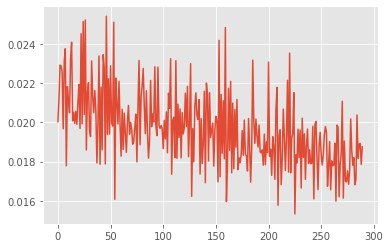

In [33]:
if DEEP_SET:
    model = DEEP_SET(DEFAULT_BATCH_SIZE, DEFAULT_HIDDEN_SIZE, DEFAULT_BATCH_SIZE)
else:
    model = RNN(DEFAULT_BATCH_SIZE, DEFAULT_HIDDEN_SIZE, DEFAULT_BATCH_SIZE)

optimizer = torch.optim.Adam(model.parameters(), lr=DEFAULT_LEARNING_RATE)
criterion = nn.MSELoss()

train()

evaluate()